# TEXT ANALYTICS GROUP ASSIGNMENT 1

#### Group Members: Brooks Beckelman, Zack Bilderback, Dallas Griffin, Estevan Gonzalez, Sean Kessel, Davis Townsend

In [1]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import brown
from nltk.tokenize import RegexpTokenizer

import pandas as pd
from pandas import Series, DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
jobs = pd.read_csv("..\..\Assignments\Assignment1\Train_rev1.csv")

## Part A (Basic Text Mining)

Due to the size of the data set, we decided to use only a sample of 50,000 descriptions for part A. We believe that this sample will do an adequate job of representing the entire data set.

In [ ]:
train = jobs.sample(10000)

# Tokenize all job descriptions from sample
jobs['tokenized_strip'] = jobs.apply(lambda row: row['FullDescription'].decode('utf-8').strip(),axis=1)
jobs['tokenized'] = jobs.apply(lambda row: nltk.word_tokenize(row['tokenized_strip']),axis=1)

### A1. Top 5 PoS in Corpus

In [10]:
#Create list of job descriptions
descriptions = []

for index, value in train.iterrows():
    descriptions.append(value['FullDescription'])

In [11]:
pos_list = []

for tok in descriptions:
    pos_list.append(nltk.pos_tag(tok))

KeyboardInterrupt: 

In [ ]:
tokens, pos = zip(*pos_list) # Unzip all_PoS to separate list of tokens from list of parts of speech
pos_freq = nltk.FreqDist(pos) # Frequency of each part of speech
top5_pos = pos_freq.most_common()[:5] # 5 most frequent parts of speech in corpus
top5_pos

In [6]:
# Create list of all tokens in corpus
all_tokens = []
for i in range(len(train['tokenized'])):
    all_tokens = all_tokens + train['tokenized'][i]

KeyboardInterrupt: 

In [ ]:
# Get part of speech tags for all tokens in corpus
all_PoS = nltk.pos_tag(all_tokens)

In [ ]:
tokens, PoS = zip(*all_PoS) # Unzip all_PoS to separate list of tokens from list of parts of speech
PoS_freq = nltk.FreqDist(PoS) # Frequency of each part of speech
top5_PoS = PoS_freq.most_common()[:5] # 5 most frequent parts of speech in corpus
top5_PoS

The 5 most common parts of speech in this corpus along with their respective frequencies are:
1. Noun, singular or mass: 46,389
2. Proper noun, singular: 33,742
3. Preposition or Subordinating Conjunction: 25,724
4. Adjective: 22,063
5. Determiner: 20,188

### A2. Zipf's Law, 100 Most Common Words

In [ ]:
from nltk.tokenize import RegexpTokenizer
word_tokenizer = RegexpTokenizer(r'\w+')

# Get list of words without punctuation for each job description
train['tokenized_words'] = train.apply(lambda row: word_tokenizer.tokenize(row['tokenized_strip']),axis=1)

# Create list of words from all job descriptions
all_words = []
for i in range(len(train['tokenized_words'])):
    all_words = all_words + train['tokenized_words'][i]

# Make all words lowercase
words_lower = []
for word in all_words:
    words_lower.append(word.lower())

In [ ]:
# Find 100 most frequent words
words_freq = nltk.FreqDist(words_lower)
top100_words = words_freq.most_common()[:100]

# Get values for expected frequency of top 100 words using Zipf's Law
max_freq = top100_words[0][1]
counter = 1
zipf = []
while len(zipf) < 100:
    zipf.append(max_freq/counter)
    counter += 1

# Plot actual frequencies and Zipf frequencies
plot([b for (a,b) in top100_words], label = 'Word Frequency') # Blue
plot(zipf, label = 'Zipf Predicted Frequency') # Green
legend(loc='best')
xlabel('Rank')
ylabel('Frequency')

### A3. Top 10 Words after Stemming and Removing Stop Words

In [ ]:
# Remove stop words
from nltk.corpus import stopwords
no_stops_words = [word for word in words_lower if word not in stopwords.words('english')]

In [ ]:
from nltk.stem.porter import PorterStemmer
PS = PorterStemmer()

# Perform stemming on words
stem_words = []
for word in no_stops_words:
    stem_word = PS.stem(word)
    stem_words.append(stem_word)

In [ ]:
# Find 10 most frequent words
words_freq_no_stops = nltk.FreqDist(stem_words)
top10_words = words_freq_no_stops.most_common()[:10]

top10_words

Due to the size of the data set, we chose to use stemming rather than lemmatization. This resulted in a list of the top 10 word stems rather than words themselves or lemmas. However, given the context, the lemmas for each stem can be estimated. 

The 10 most frequent word stems with their likely associated lemmas are listed below, along with their respective frequencies:
1. 'work' (work) - 2141
2. 'manag' (manage) - 2049
3. 'experi'(experience) - 1642
4. 'role' (role) - 1246
5. 'team' (team) - 1226
6. 'busi' (business) - 1213
7. 'client' (client) - 1206
8. 'develop' (develop) - 1150
9. 'requir' (require) - 1018
10. 'servic' (service) - 1017

## Part B (Predict Salary from Job Description)

### B1. Bag of Words

In [7]:
train = jobs[['FullDescription', 'SalaryNormalized']]

#Create new classifier for job posting salaries in the top quartile
sal_75 = train['SalaryNormalized'].quantile(.75)
train['salary_class'] = np.where(train['SalaryNormalized']>=sal_75,'high','low')
train.head()

C:\Users\brook\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,FullDescription,SalaryNormalized,salary_class
0,Engineering Systems Analyst Dorking Surrey Sal...,25000,low
1,Stress Engineer Glasgow Salary **** to **** We...,30000,low
2,Mathematical Modeller / Simulation Analyst / O...,30000,low
3,Engineering Systems Analyst / Mathematical Mod...,27500,low
4,"Pioneer, Miser Engineering Systems Analyst Do...",25000,low


In [8]:
#Create two separate lists for text and salary classifier for each job posting
descriptions = []
pay_class = []

for index, value in train.iterrows():
    descriptions.append(value['FullDescription'])
    pay_class.append(value['salary_class'])

In [24]:
#Split data into test/training set
trainset_size = int(round(len(train)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay_class[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay_class[trainset_size+1:len(pay_class)]]) 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer= None,
                             preprocessor = None, 
                             stop_words = None)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [11]:
from sklearn.naive_bayes import MultinomialNB

#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [12]:
from sklearn.naive_bayes import MultinomialNB

#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [13]:
from sklearn import metrics
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.557522496005
Recall: 0.802748683175
Accuracy: 0.7747871419


C:\Users\brook\Anaconda2\lib\site-packages\seaborn\matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
C:\Users\brook\Anaconda2\lib\site-packages\seaborn\matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


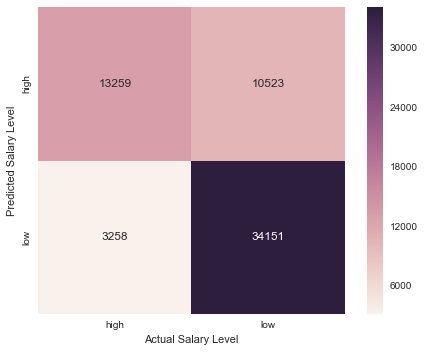

In [14]:
#Fancy boy confusion matrix
import seaborn as sns; sns.set()

mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay_class), yticklabels=unique(pay_class))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');

The model using the bag-of-words approach was very accurate, predicting the salary level correct for over 77% of the job descriptions.

### B2. Lemmatization

We believe that lemmatization will help improve the accuracy of classification. 

In [41]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [42]:
train = jobs[['FullDescription', 'SalaryNormalized']]

all_desc_lem = []
for i in train["FullDescription"]:
    wrds = i.split()
    wrds_lem = []
    for j in wrds:
        wrds_lem.append(lmtzr.lemmatize(j.decode('utf-8')))
    desc_lem = " ".join(wrds_lem)
    all_desc_lem.append(desc_lem)

pd.Series(all_desc_lem).head()

0    Engineering Systems Analyst Dorking Surrey Sal...
1    Stress Engineer Glasgow Salary **** to **** We...
2    Mathematical Modeller / Simulation Analyst / O...
3    Engineering Systems Analyst / Mathematical Mod...
4    Pioneer, Miser Engineering Systems Analyst Dor...
dtype: object

In [43]:
trainset_size = int(round(len(train)*0.75))

X_train = np.array([''.join(el) for el in all_desc_lem[0:trainset_size]])
y_train = np.array([el for el in pay_class[0:trainset_size]])

X_test = np.array([''.join(el) for el in all_desc_lem[trainset_size+1:len(all_desc_lem)]]) 
y_test = np.array([el for el in pay_class[trainset_size+1:len(pay_class)]]) 

In [44]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer= None,
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = None)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [45]:
#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [46]:
print y_nb_predicted

['low' 'high' 'low' ..., 'low' 'low' 'high']


In [47]:
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.556837318963
Recall: 0.80075074166
Accuracy: 0.774198820088


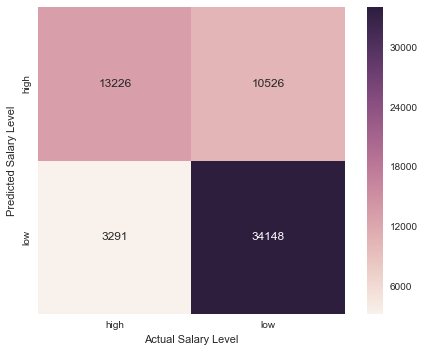

In [48]:
#Fancy boy confusion matrix
mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay_class), yticklabels=unique(pay_class))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');

Contrary to our prediction, the classification accuracy was virtually unchanged after lemmatization. In fact, the accuracy went down ever so slightly from about 77.47% to about 77.42%.

### B3. Stopwords Removal

We believe that removing stopwords will help increase the accuracy of the original model.

In [25]:
#Split data into test/training set
trainset_size = int(round(len(train)*0.75))

X_train = np.array([''.join(el) for el in descriptions[0:trainset_size]])
y_train = np.array([el for el in pay_class[0:trainset_size]])

X_test = np.array([''.join(el) for el in descriptions[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay_class[trainset_size+1:len(pay_class)]]) 

In [26]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer= None,
                             preprocessor = None, 
                             stop_words = 'english', 
                             max_features = None)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [27]:
#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [28]:
print y_nb_predicted

['low' 'high' 'low' ..., 'low' 'low' 'high']


In [29]:
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

Precision:0.560580704544
Recall: 0.811224798692
Accuracy: 0.777401905509


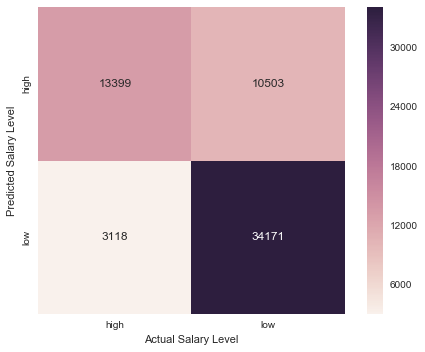

In [30]:
#Fancy boy confusion matrix
mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay_class), yticklabels=unique(pay_class))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');

As we expected, removing stopwords improved the accurracy of the bag-of-words model. However, the improvement was not nearly as significant as we expected with the accuracy only increasing from about 77.4% to about 77.7%. This is also slightly better than the results from B2 (after lemmatization). 

### B4. PoS Bigrams

In [ ]:
pos_list = []
for tok in descriptions:
    pos_list.append(nltk.pos_tag(tok))

In [ ]:
#POS appended to word
comb = []
for pos in pos_list:
    to_string = ""
    for a, b in pos:
        to_string += a + "_" + b + " "
    comb.append(to_string)

In [ ]:
#Split data into test/training set
trainset_size = int(round(len(train)*0.75))

X_train = np.array([''.join(el) for el in comb[0:trainset_size]])
y_train = np.array([el for el in pay_class[0:trainset_size]])

X_test = np.array([''.join(el) for el in comb[trainset_size+1:len(descriptions)]]) 
y_test = np.array([el for el in pay_class[trainset_size+1:len(pay_class)]])

In [ ]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer= None,
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = None, ngram_range=(1, 2))

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
#Run Naive Bayes Classifier
nb_classifier = MultinomialNB().fit(X_train, y_train)

y_nb_predicted = nb_classifier.predict(X_test)

In [ ]:
print 'Precision:' + str(metrics.precision_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Recall: ' + str(metrics.recall_score(y_test, y_nb_predicted, average = 'binary', pos_label='high'))
print 'Accuracy: ' + str(metrics.accuracy_score(y_test, y_nb_predicted))

In [ ]:
#Fancy boy confusion matrix
mat = metrics.confusion_matrix(y_test, y_nb_predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=unique(pay_class), yticklabels=unique(pay_class))
plt.xlabel('Actual Salary Level')
plt.ylabel('Predicted Salary Level');